# Messung einer akustischen Impulsantwort

Messung und Berechnung einer akustischen Impulsantwort durch Abspielen eines Sweep-Signals mit der Soundkarte, zeitsynchrones Aufnehmen der Raumantwort und spektrale Division.

*Modul Signal- und Systemtheorie, Institut für Nachrichtentechnik, Universität Rostock
(c) Sascha Spors, [Sascha.Spors@uni-rostock.de](mailto:Sascha.Spors@uni-rostock.de)*

### Initialisierung

Das Paket `sounddevice` bietet Python Zugriff auf die Soundkarte mittels `portaudio`. Dokumentation und Installationsanleitung zu `sounddevice` unter <http://python-sounddevice.readthedocs.org/> und zu `portaudio` unter <http://www.portaudio.com/>.

In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import scipy.signal as signal
import sounddevice as sd

### Erzeugung des Messsignals

Als Messsignal wird ein abgetasteter linearer Sweep $x(t) = A \sin \left( \frac{\omega_{stop} - \omega_{start}}{2 T} t^2 +  \omega_{start} t \right)$ verwendet. Dieser hat gegenüber einer Impulsfolge $\delta[k]$ den Vorteil eines niedrigen Crest-Faktors.

In [2]:
fs = 44100  # Abtastrate
T = 5  # Länge des Messsignals in Sekunden
Tr = 2  # Länge der Systemantwort in Sekunden

t = np.linspace(0, T, T*fs)
x = signal.chirp(t, 20, T, 20000, 'linear', phi=90)
x = 0.9 * x / np.max(np.abs(x))

Das Betragsspektrum $|H(e^{j \Omega})|$ mit $\Omega = \frac{\omega}{f_s} = \frac{2 \pi f}{f_s}$ des Sweep-Signals ist im Frequenzbereich von $\omega_{start}$ bis $\omega_{stop}$ nahezu konstant

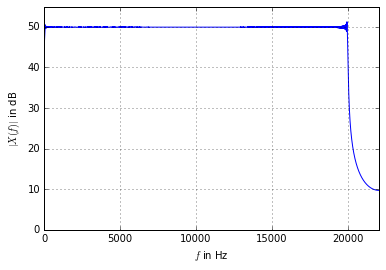

In [3]:
X = np.fft.rfft(x)
f = np.fft.rfftfreq(len(x))*fs

plt.plot(f, 20*np.log10(np.abs(X)))
plt.xlabel(r'$f$ in Hz')
plt.ylabel(r'$|X(f)|$ in dB')
plt.grid()
plt.axis([0, fs/2, 0, 55]);

### Abspielen des Messsignals und Aufnehmen der Systemantwort

Zeitsynchrones Abspielen des Messsignals $x[k]$ und der Systemantwort $y[k]$ über den Aus- und Eingang der Soundkarte. Da die Länge des aufgenommenen Signals mit der Länge des abgespielten Signals übereinstimmen muss, wird dieses vorher mit Nullwerten aufgefüllt damit die Systemantwort mit aufgenommen wird.

In [4]:
x = np.concatenate((x, np.zeros(Tr*fs)))
y = sd.playrec(x, fs, channels=1)
sd.wait()
y = np.squeeze(y)

print('Ausgangspegel: ', 20*np.log10(max(x)), ' dB')
print('Eingangspegel: ', 20*np.log10(max(y)), ' dB')

Ausgangspegel:  -0.915149812185  dB
Eingangspegel:  8.94747127182  dB


### Berechnung der Impulsantwort

Die Impulsantwort wird mittels spektraler Divison berechnet $h[k] = \text{IDFT}_N \left\{ \frac{ \text{DFT}_N \{ y[k] \}}{\text{DFT}_N \{ x[k] \}} \right\} $. Durch das vorherige Auffüllen des Messsignals mit Nullwerten wird eine zyklische Umfaltung bei der Berechnung der Impulsantwort vermieden.

In [5]:
H = np.fft.rfft(y) / np.fft.rfft(x)
h = np.fft.irfft(H)

h = h[0:Tr*fs]

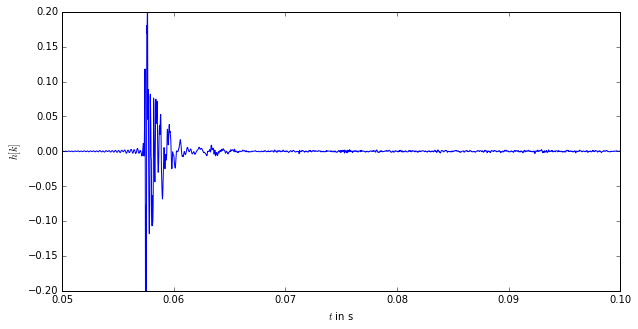

In [6]:
plt.figure(figsize=(10, 5))
t = 1/fs * np.arange(len(h))
plt.plot(t, h)
plt.axis([0.05, .1, -0.2, 0.2])
plt.xlabel(r'$t$ in s')
plt.ylabel(r'$h[k]$');